## PINNs for Steady Cavity Problem With Cylinder

Solving the 2D steady diffusion equation using a Physics Informed Neural Network (PINN).  

### Governing Equations

The equations for the 2D steady Navier-Stokes problem are given by:

$$
\begin{cases}
\cancel{\frac{\partial u}{\partial t}} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)  \\
\cancel{\frac{\partial v}{\partial t}} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
\end{cases}
$$



### Continuity Equation

The continuity equation for incompressible flow is:

$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
$$

### Momentum Equations

In terms of the components, the momentum equations are:

$$
u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} + \frac{\partial p}{\partial x} = \frac{1}{Re} \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$

$$
u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} + \frac{\partial p}{\partial y} = \frac{1}{Re} \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
$$

where \( Re \) is the Reynolds number.

### Domain

The domain for x and y is:
$$
 x \in [0,1] \quad \text{and } \quad  y \in [0,1] .
$$

### Initial and Boundary Conditions

The boundary conditions (BCs) for this problem are as follows:

- For \( u \) and \( v \):

$$
u(0, y) = 0 \quad \text{for } y \in [0, 1]
$$

$$
u(1, y) = 0 \quad \text{for } y \in [0, 1]
$$

$$
u(x, 0) = 0 \quad \text{for } x \in [0, 1]
$$

$$
u(x, 1) = u_i \quad \text{for } x \in [0, 1] \quad (u_i \text{ is the top wall's velocity})
$$

$$
v(0, y) = 0 \quad \text{for } y \in [0, 1]
$$

$$
v(1, y) = 0 \quad \text{for } y \in [0, 1]
$$

$$
v(x, 0) = 0 \quad \text{for } x \in [0, 1]
$$

$$
v(x, 1) = 0 \quad \text{for } x \in [0, 1]
$$

## Cylinder's Affect
Incorporating a cylinder at the center of the domain introduces additional boundary conditions that govern the fluid flow behavior:

No-Slip Boundary Condition: no-slip boundary condition along its surface.
$$
u(r=R) \cdot {\hat \theta} = 0 \quad ,\quad  v(r=R)\cdot {\hat \theta} = 0  \quad \text{for }\quad  r=R \quad and \quad \theta  \in  [0, 2 \pi] 
$$



Impenetrability Condition: the fluid cannot penetrate the cylinder's interior.
$$
u(r=R) \cdot {\hat r} = 0 \quad ,\quad  v(r=R)\cdot {\hat r} = 0  \quad \text{for } \quad  r=R \quad and \quad \theta  \in  [0, 2 \pi] \quad \text{cylinder's surface}
$$

$$
u(r<R) = 0 \quad ,\quad  v(r=R)= 0  \quad \text{for }\quad  r<R \quad and \quad \theta  \in  [0, 2 \pi] \quad \text{cylinder's internal}
$$


### Loss Function for PINN

In the context of a Physics Informed Neural Network (PINN), the loss function includes terms to enforce these equations and boundary conditions:

- Residuals of the Navier-Stokes equations and continuity equation.
- Boundary conditions for \( u \) and \( v \).

The loss function can be represented as:

$$
\text{Loss} = \text{Loss}{\text{equations}} + \text{Loss}{\text{boundary conditions}}
$$

Where:
- $ \text{Loss}_{\text{equations}} $ ensures that the predicted solutions satisfy the Navier-Stokes and continuity equations.
- $ \text{Loss}_{\text{boundary conditions}} $ ensures that the boundary conditions are met.


In [1]:
import torch
import torch.nn as nn
from torch.autograd import grad
import torch.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:1")     # NVIDIA GPUs
elif torch.backends.mps.is_available():
    device = torch.device("mps")        # Apple silicon (metal performance shaders)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cpu


### Define PINNs network class with Fourier Feature Mapping

In [3]:
class ffm(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.B = nn.Parameter(torch.normal(mean=0, std=10, size=(in_dim, out_dim), requires_grad=False))
    
    def forward(self, x):
        x_map = torch.matmul(x, self.B)
        return torch.cat([torch.cos(x_map), torch.sin(x_map)], -1)

class PINNs_net(nn.Module):    
    def __init__(self, in_dim=2, HL_dim=64, out_dim=3, activation=nn.Tanh()):
        super().__init__()

        network = [ffm(in_dim, HL_dim),
                   nn.Linear(HL_dim*2, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, HL_dim), activation,
                   nn.Linear(HL_dim, out_dim)]
        
        # define the network using sequential method
        self.net = nn.Sequential(*network) 
        
    def forward(self, x, y):
        return self.net(torch.cat((x, y), 1))
    

    def compute_loss(self, x, y, Nx, Ny, u_i, cyl):
        """
        This is the physics part really
        """
        Re = 100
        x.requires_grad=True
        y.requires_grad=True
        net_out = self.net(torch.cat((x,y), 1))   # input size: [Nx*Ny,2], output size: [Nx*Ny,3]

        u = net_out[:,0]
        v = net_out[:,1]
        p = net_out[:,2]
  
        u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_yy = grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

        v_x = grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]  # Change 5: Added gradients for v
        v_y = grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_xx = grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_yy = grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

        p_x = grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_y = grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

        # set a loss function to apply to each of the physics residuals (PDE, BC)
        loss_fun = nn.MSELoss()

        # compute the PDE residual loss
        res1 = u_x + v_y
        res2 = u*u_x + v*u_y + p_x - 1/Re*(u_xx+u_yy)
        res3 = u*v_x + v*v_y + p_y - 1/Re*(v_xx+v_yy)
        pde_loss = loss_fun(res1, torch.zeros_like(res1)) + loss_fun(res2, torch.zeros_like(res2)) + loss_fun(res3, torch.zeros_like(res3))

        # compute the BC loss
        u_reshaped = u.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Ny]
        v_reshaped = v.view(Nx, Ny) # [Nx*Ny, 1] -> [Nx, Ny]
 
        bc_loss = loss_fun(u_reshaped[0, :], torch.zeros_like(u_reshaped[0,:])) \
                + loss_fun(u_reshaped[-1, :], torch.zeros_like(u_reshaped[Nx-1,:])) \
                + loss_fun(v_reshaped[0, :], torch.zeros_like(v_reshaped[0,:])) \
                + loss_fun(v_reshaped[-1, :], torch.zeros_like(v_reshaped[Nx-1,:])) \
                + loss_fun(u_reshaped[:, 0], torch.zeros_like(u_reshaped[:,Ny-1])) \
                + loss_fun(v_reshaped[:,0], torch.zeros_like(v_reshaped[:,Ny-1])) \
                + loss_fun(u_reshaped[:, -1], torch.ones_like(u_reshaped[:, -1]) * u_i) \
                + loss_fun(v_reshaped[:, -1], torch.zeros_like(v_reshaped[:, -1])) \
                 + loss_fun(u_reshaped[cyl==True] , torch.zeros_like(u_reshaped[cyl==True])) \
                 + loss_fun(v_reshaped[cyl==True] , torch.zeros_like(v_reshaped[cyl==True]))

        return pde_loss, bc_loss


### Define Model and Optimizer

In [4]:
model = PINNs_net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Setting up the Case

In [5]:
# num of points in the domain
Nx, Ny = 200, 200
u_i = 5 #m/s
R=0.1 #cylinder's radius
# define domain dimensions and resolution
Lx_initial, Lx_final = 0, 1
Ly_initial, Ly_final = 0, 1
x_center = (Lx_final - Lx_initial)/2
y_center = (Ly_final - Ly_initial)/2
dx = (Lx_final - Lx_initial) / (Nx - 1)
dy = (Ly_final - Ly_initial) / (Ny-1)

# initiallize input parameters as tensors
x = torch.zeros(Nx, Ny)
y = torch.zeros(Nx, Ny)
cyl=torch.zeros(Nx,Ny, dtype=torch.bool)
for i in range(Nx):
    for j in range(Ny):
        x[i,j] = Lx_initial + dx * i
        y[i,j] = Ly_initial + dy * j
        if (float(x[i,j])-x_center)**2 + (float(y[i,j])-y_center)**2 <= R**2:
            cyl[i,j] = True
print(type(cyl))
print(cyl.shape)
print(cyl.max())
cyl = cyl.to(device)
x = x.to(device)
y = y.to(device)

<class 'torch.Tensor'>
torch.Size([64, 64])
tensor(True)


### Training the PINNs network

In [6]:
N_epoches = 50000
loss_per_epoch = np.zeros((N_epoches,3))
for epoch in range(N_epoches):
    # compute various losses
    eq_loss, BC_loss = model.compute_loss(x.view(-1,1), y.view(-1,1), Nx, Ny , u_i ,cyl)

    # compute total loss
    total_loss = eq_loss + 10*BC_loss

    # backward pass
    total_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_per_epoch[epoch,0] = eq_loss
    loss_per_epoch[epoch,1] = BC_loss
    loss_per_epoch[epoch,2] = total_loss
    print(f"epoch: {epoch}, loss: {total_loss}")


epoch: 0, loss: 273.53045654296875
epoch: 1, loss: 264.701171875
epoch: 2, loss: 256.34820556640625
epoch: 3, loss: 248.072509765625
epoch: 4, loss: 239.5596923828125
epoch: 5, loss: 230.57025146484375
epoch: 6, loss: 220.92312622070312
epoch: 7, loss: 210.5009765625
epoch: 8, loss: 199.27664184570312
epoch: 9, loss: 187.34329223632812
epoch: 10, loss: 174.93206787109375
epoch: 11, loss: 162.39404296875
epoch: 12, loss: 150.1444549560547
epoch: 13, loss: 138.57992553710938
epoch: 14, loss: 127.97418212890625
epoch: 15, loss: 118.44108581542969
epoch: 16, loss: 110.01591491699219
epoch: 17, loss: 102.72158813476562
epoch: 18, loss: 96.65180969238281
epoch: 19, loss: 91.78767395019531
epoch: 20, loss: 87.6709213256836
epoch: 21, loss: 83.79402160644531
epoch: 22, loss: 80.19900512695312
epoch: 23, loss: 76.83086395263672
epoch: 24, loss: 73.39120483398438
epoch: 25, loss: 69.84037780761719
epoch: 26, loss: 66.3682632446289
epoch: 27, loss: 63.36772918701172
epoch: 28, loss: 61.0504074096

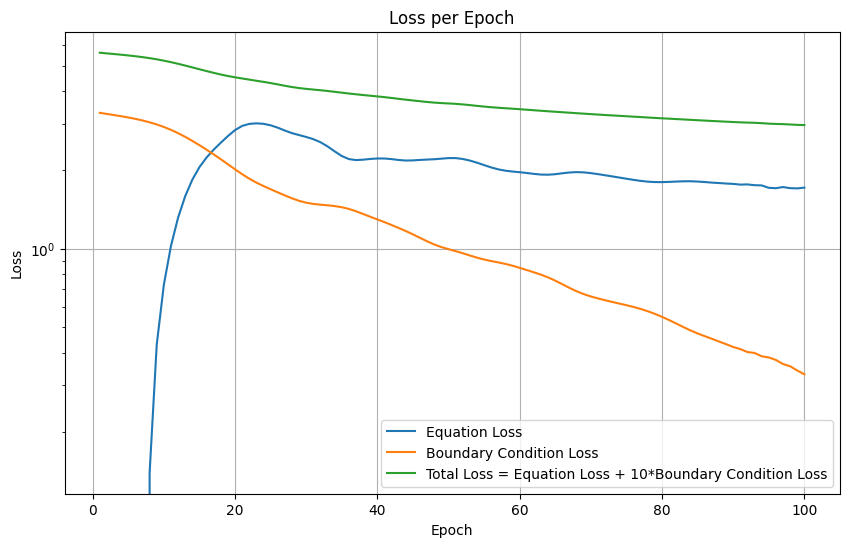

In [7]:
epocs_array = np.linspace(1,N_epoches,N_epoches)

plt.figure(figsize=(10, 6))  # Optional: specify the figure size
plt.plot(epocs_array, np.log(loss_per_epoch[:,0]), '-')
plt.plot(epocs_array, np.log(loss_per_epoch[:,1]), '-')
plt.plot(epocs_array, np.log(loss_per_epoch[:,2]), '-')

plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True) 
plt.legend(['Equation Loss','Boundary Condition Loss','Total Loss = Equation Loss + 10*Boundary Condition Loss'])

# Show the plot
plt.show()

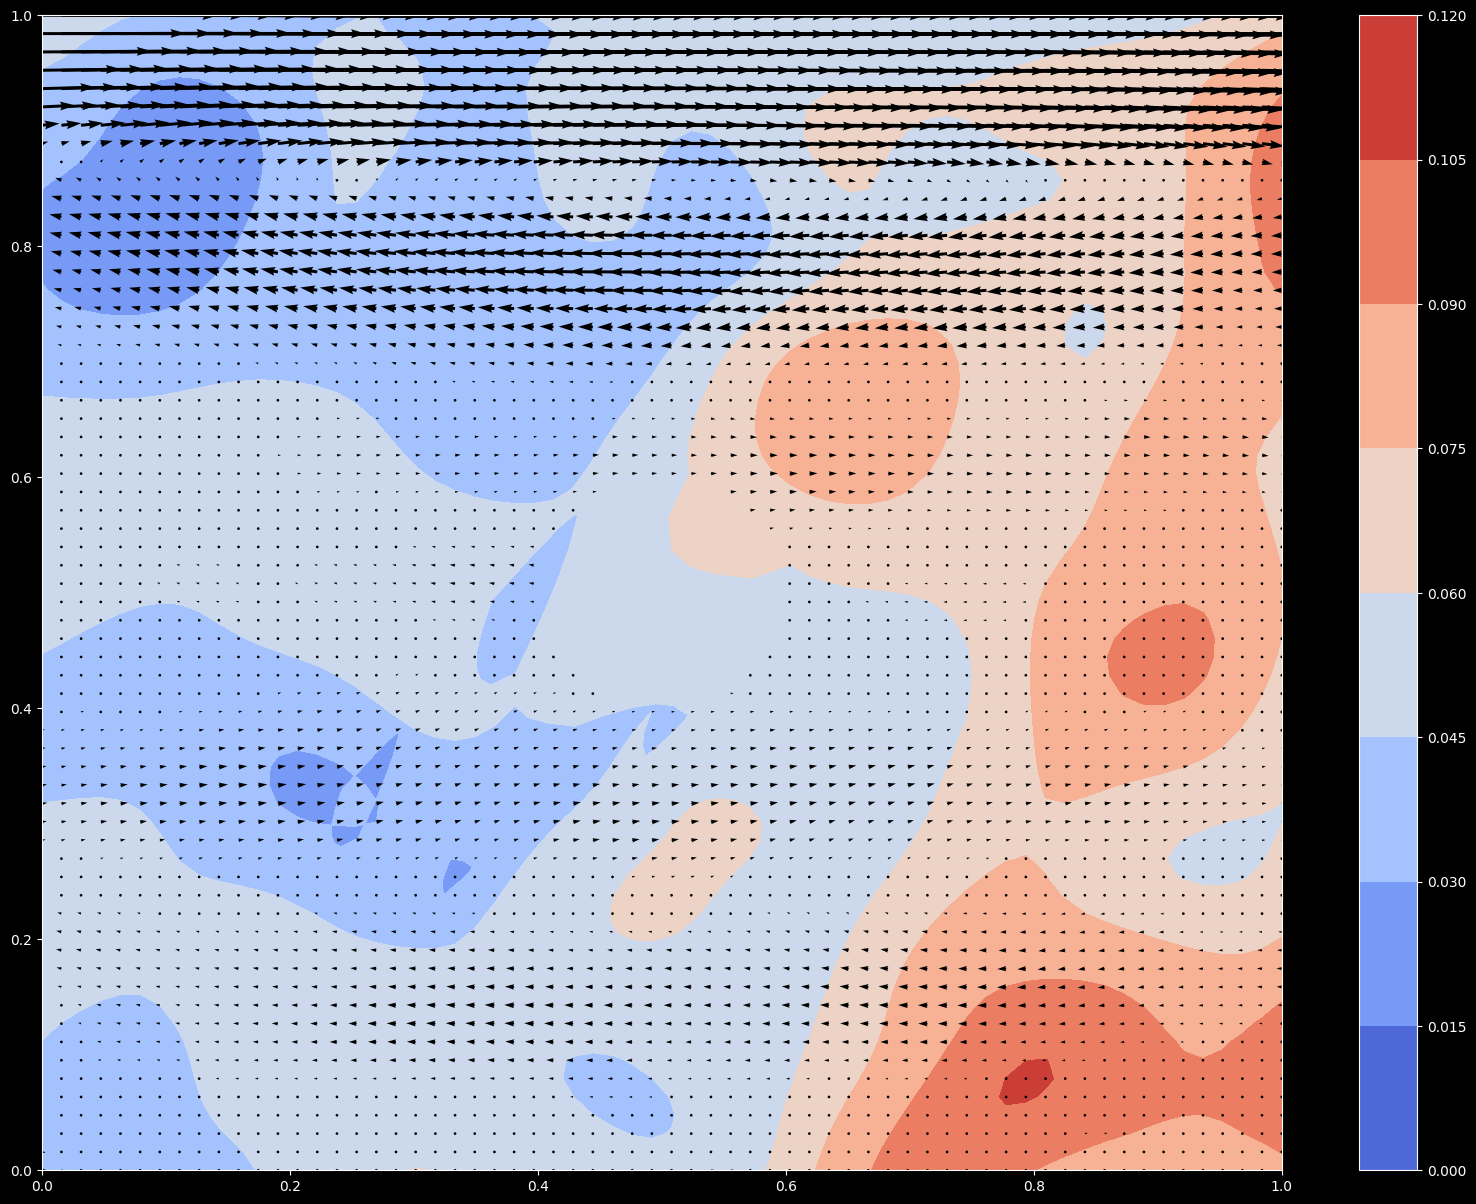

In [8]:
x_np = x.detach().numpy()
y_np = y.detach().numpy()
cyl_np = cyl.detach().numpy()

net = model.forward(x.view(-1,1), y.view(-1,1)) # convert x tensor into a column vector
u=net[:, 0]
v=net[:, 1]
p=net[:, 2]

u_np = u.detach().numpy().reshape(Nx,Ny) # convert into a np array
v_np = v.detach().numpy().reshape(Nx,Ny) # convert into a np array
p_np = p.detach().numpy().reshape(Nx,Ny) # convert into a np array

# bring back the variable to the CPU for plotting
# u_np = u_np.to('cpu')
# v_np = v_np.to('cpu')
# p_np = p_np.to('cpu')

plt.style.use("dark_background")
plt.figure(figsize=(20, 15))
plt.contourf(x_np*(cyl_np==False) , y_np*(cyl_np==False), p_np*(cyl_np==False), cmap="coolwarm")
# plt.contourf(x_np[::2,::2] , y_np[::2,::2], u_np[::2,::2],v_np[::2,::2], cmap="coolwarm")
plt.colorbar()
plt.quiver(x_np*(cyl_np==False), y_np*(cyl_np==False) , u_np*(cyl_np==False)  , v_np*(cyl_np==False) , color="black", scale=25)
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

#Save and Read Data

In [9]:
#save the data as new .npz file
np.savez('PINNs_Caviti_Cylinder_workspace.npz', x_np=x_np,y_np=y_np,u_np=u_np,v_np=v_np,p_np=p_np,cyl_np=cyl_np)


In [13]:
#read data from .npz file
data = np.load('PINNs_Caviti_Cylinder_workspace.npz')

x_read= data['x_np']
y_read= data['y_np']
u_read= data['u_np']
v_read= data['v_np']
p_read= data['p_np']
cyl_read= data['cyl_np']
